In [1]:
%matplotlib inline

In [2]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *

In [3]:
#The first time this will download a dataset that is ~650mb
path = untar_data(URLs.ESC50) 

The audio files are inside a subfolder `audio/`

In [4]:
(path/"audio").ls()

(#2000) [Path('/home/scart/.fastai/data/master/audio/5-198891-A-8.wav'),Path('/home/scart/.fastai/data/master/audio/3-128512-A-47.wav'),Path('/home/scart/.fastai/data/master/audio/4-234879-A-6.wav'),Path('/home/scart/.fastai/data/master/audio/3-100024-A-27.wav'),Path('/home/scart/.fastai/data/master/audio/5-263831-A-6.wav'),Path('/home/scart/.fastai/data/master/audio/1-22804-A-46.wav'),Path('/home/scart/.fastai/data/master/audio/2-117615-A-48.wav'),Path('/home/scart/.fastai/data/master/audio/5-221518-A-21.wav'),Path('/home/scart/.fastai/data/master/audio/2-43802-A-42.wav'),Path('/home/scart/.fastai/data/master/audio/5-194899-D-3.wav')...]

And there's another folder `meta/` with some metadata about all the files and the labels

In [5]:
(path/"meta").ls()

(#2) [Path('/home/scart/.fastai/data/master/meta/esc50.csv'),Path('/home/scart/.fastai/data/master/meta/esc50-human.xlsx')]

Opening the metadata file

In [6]:
df = pd.read_csv(path/"meta"/"esc50.csv")
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


Looking at the fold attribute, this dataset has a 5 fold cross validation setup

In [7]:
df["fold"].value_counts()

5    400
4    400
3    400
2    400
1    400
Name: fold, dtype: int64

## Datablock and Basic End to End Training on 10 Speakers

In [8]:
def CrossValidationSplitter(col='fold', fold=1):
    "Split `items` (supposed to be a dataframe) by fold in `col`"
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

In [9]:
cfg = AudioConfig.BasicMelSpectrogram()
a2s = AudioToSpec.from_cfg(cfg)

In [10]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_x=ColReader("filename", pref=path/"audio"), 
                 splitter=CrossValidationSplitter(fold=1),
                 batch_tfms = [a2s],
                 get_y=ColReader("category"))

In [11]:
dbunch = auds.dataloaders(df, bs=64)

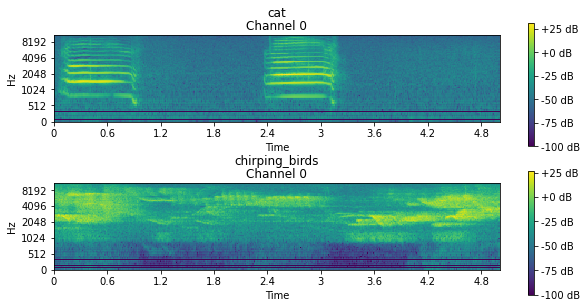

In [13]:
dbunch.show_batch(figsize=(10, 5))

In [23]:
learn = cnn_learner(dbunch, 
                    resnet18, 
                    config=cnn_config(n_in=1),
                    loss_fn=CrossEntropyLossFlat,
                    metrics=[accuracy]                 
                    )

In [15]:
# Run 1
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,5.362637,3.841287,0.062500,00:06
1,4.346826,2.322840,0.367500,00:05
2,3.214310,1.731682,0.532500,00:05
3,2.375317,1.548108,0.567500,00:05
4,1.752864,1.415037,0.617500,00:05
5,1.342314,1.364263,0.622500,00:05
6,1.061177,1.327009,0.622500,00:05
7,0.846268,1.299848,0.630000,00:05
8,0.711047,1.282081,0.627500,00:05
9,0.625446,1.289850,0.632500,00:05


In [18]:
# Run 2
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,5.451436,3.835509,0.072500,00:05
1,4.394065,2.408547,0.362500,00:05
2,3.235223,1.851665,0.475000,00:05
3,2.401047,1.614048,0.527500,00:05
4,1.781511,1.444327,0.615000,00:05
5,1.351034,1.374377,0.620000,00:05
6,1.052522,1.336456,0.612500,00:05
7,0.850513,1.311344,0.617500,00:05
8,0.716422,1.297140,0.622500,00:05
9,0.626075,1.300961,0.627500,00:05


In [20]:
# Run 3
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,5.357991,3.762291,0.070000,00:05
1,4.416282,2.346620,0.380000,00:05
2,3.283634,1.785188,0.515000,00:05
3,2.411550,1.598440,0.545000,00:05
4,1.805195,1.504222,0.590000,00:05
5,1.343165,1.397719,0.597500,00:05
6,1.053858,1.359933,0.607500,00:05
7,0.856317,1.364997,0.605000,00:05
8,0.707458,1.345314,0.620000,00:05
9,0.623853,1.344256,0.612500,00:05


In [22]:
# Run 4
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,5.385759,3.798428,0.075000,00:05
1,4.396407,2.330294,0.410000,00:05
2,3.259960,1.819184,0.512500,00:05
3,2.413594,1.563922,0.567500,00:05
4,1.789973,1.456120,0.605000,00:05
5,1.362808,1.388336,0.610000,00:05
6,1.071332,1.334179,0.622500,00:05
7,0.853096,1.312686,0.612500,00:05
8,0.717839,1.316776,0.632500,00:05
9,0.626494,1.301849,0.630000,00:05


In [24]:
# Run 5
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,5.460725,3.942836,0.080000,00:05
1,4.455307,2.509840,0.335000,00:05
2,3.278327,1.868334,0.500000,00:05
3,2.397520,1.614712,0.562500,00:05
4,1.793488,1.460452,0.615000,00:05
5,1.349562,1.407148,0.602500,00:05
6,1.054251,1.363251,0.630000,00:05
7,0.851631,1.359619,0.632500,00:05
8,0.698936,1.346929,0.637500,00:05
9,0.609166,1.338432,0.640000,00:05


In [25]:
# Final result
sum([0.632500, 0.627500, 0.612500, 0.630000, 0.640000]) / 5

0.6285000000000001